# CDR Experiments via Pymagicc
##### CC-BY 4.0 2020 @safiume

In [1]:
# NBVAL_IGNORE_OUTPUT
import sys, re
from os import listdir
from os.path import join, dirname
from pprint import pprint
import expectexception
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import f90nml

In [2]:
#Disable warning supression if running locally
import warnings
warnings.simplefilter("ignore", category=Warning, lineno=0, append=False)

In [3]:
import pymagicc
from pymagicc import MAGICC6
from pymagicc.io import MAGICCData, read_cfg_file, NoReaderWriterError
from pymagicc.scenarios import ( rcp26, rcp45, rcps )
print(pymagicc.__version__)
print(sys.version)
rcp26.__class__.__bases__

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


2.0.0rc8+19.g7aade1e
3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


(scmdata.run.ScmRun,)

In [4]:
##Start of Magic settings
magcfg = { #"startyear" : 1765,
          "endyear" : 2500,
          "core_climatesensitivity" : 3,
          "co2_switchfromconc2emis_year" : 2010,
          "rf_mhalo_constantafteryr" : 2250,
          "rf_fgas_constantafteryr" : 2250,
          "out_forcing" : 1,
          "out_emissions" : 1,
          "out_concentrations" : 1 }
### End MAGICC Settings

In [5]:
## declines to run
SCEN_DIR = "SCEN"
MAGICC6_DIR = join("..", "CDRRUN")
declinefile = join(SCEN_DIR, "ONC" + "lmin" + ".SCEN")
oncdata = MAGICCData(declinefile, columns={"model": ["CDRex"], "scenario": ['lmin']}, inplace=True)
rcps = rcps.append(oncdata)
print(rcps["scenario"].unique())
rcps.filter(scenario='lmin').timeseries().head(3)

['RCP26' 'lmin']


time                                                                                             2000-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                     Emissions|CO2|MAGICC AFOLU                                  NaN   
                                         Mt CH4 / yr Emissions|CH4                                               NaN   

time                                                                                             2001-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                     Emissions|CO2|MAGICC AFOLU                                  NaN   
                                         Mt CH4 / yr Emissions|CH4                                               NaN   

time                                                                                             2002-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                     Emissions|CO2|MAGICC AFOLU                                  NaN   
                                         Mt CH4 / yr Emissions|CH4                                               NaN   

time                                                                                             2003-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                     Emissions|CO2|MAGICC AFOLU                                  NaN   
                                         Mt CH4 / yr Emissions|CH4                                               NaN   

time                                                                                             2004-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                     Emissions|CO2|MAGICC AFOLU                                  NaN   
                                         Mt CH4 / yr Emissions|CH4                                               NaN   

time                                                                                             2005-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                8.030   
                                                     Emissions|CO2|MAGICC AFOLU                                1.180   
                                         Mt CH4 / yr Emissions|CH4                                           315.903   

time                                                                                             2006-01-01 00:00:00  \
climate_model model region scenario todo unit        variable                                                          
unspecified   CDRex World  lmin     SET  Gt C / yr   Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                  

In [6]:
CRsyr = 2021
Bkyr = 2050
# CO₂ gas is in GtC
AnthroC = 455.08
LuC = 161.09
CCCxFF = 187
CCCxLuC = 103

LuC_2050 = LuC - CCCxLuC
landsnk_yrly = LuC_2050/((Bkyr) - CRsyr)
landsnc_remainingYr = CCCxLuC/(2100 - Bkyr)

AC_2050 = AnthroC - CCCxFF
Peak_to_bk_yr = AC_2050/((Bkyr) - CRsyr)
Remaining_per_yr = CCCxFF/(2100 - Bkyr)

In [7]:
CCCx2050 = rcps.filter(scenario='lmin')
src_df = CCCx2050.timeseries()
#kigali_yrs = 2019,2024,2025,2029,2034,2036
#ki_mo_gasses_F = HFC134a, HFC245fa, HFC277ea, 
#                 HFC4310, HFC32, HFC125, HFC143a, HFC23
#sf6-eu 30% by 2030
ems_ff = 'Emissions|CO2|MAGICC Fossil and Industrial'
ems_luc = 'Emissions|CO2|MAGICC AFOLU'
cx2050 = 'unspecified','CDRex','World','CCCx2050','SET','Gt C / yr'
source_cols = src_df.columns
idxs = list(range(8,len(source_cols)-3))
idxs.insert(0,5)

newcols = []
for n in idxs:
    newcols.append(source_cols[n])
CCC_df = src_df[newcols]

CCC_df = CCC_df.rename(index={"lmin":"CCCx2050"})
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_luc), datetime(2021,1,1) : datetime(2049,1,1)] = -landsnk_yrly
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_luc), datetime(2050,1,1) : datetime(2099,1,1)] = -landsnc_remainingYr
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_ff), datetime(2021,1,1) : datetime(2049,1,1)] = -Peak_to_bk_yr
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_ff), datetime(2050,1,1) : datetime(2099,1,1)] = -Remaining_per_yr 
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_ff), datetime(2100,1,1,0)] = 0
CCC_df.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_luc), datetime(2100,1,1,0)] = 0

#rewrite CCCx2050 from timeseries in line2 w/ Slices of cols in newcols
# and wrap in MAGICCData
CCCx2050 = MAGICCData(CCC_df.copy())
CCC_df.to_csv('CCCx2050.csv')
CCC_flat = CCC_df.copy()
CCC_flat.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_ff), datetime(2051,1,1,0) : datetime(2100,1,1,0)] = 0
CCC_flat.loc[('unspecified','CDRex','World','CCCx2050','SET','Gt C / yr',ems_luc), datetime(2051,1,1,0) : datetime(2100,1,1,0)] = 0
CCC_flat = CCC_flat.rename(index={"CCCx2050":"CCCxflat"})
CCCxflat = MAGICCData(CCC_flat.copy())

print(CCC_df.head(2).iloc[:,[10]])
print(CCC_df.head(4).iloc[:,[30]])
CCCx2050.timeseries().head(5)

time                                                                                           2019-01-01 00:00:00
climate_model model region scenario todo unit      variable                                                       
unspecified   CDRex World  CCCx2050 SET  Gt C / yr Emissions|CO2|MAGICC Fossil and Industrial                10.00
                                                   Emissions|CO2|MAGICC AFOLU                                 1.25
time                                                                                              2039-01-01 00:00:00
climate_model model region scenario todo unit         variable                                                       
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial            -9.244138
                                                      Emissions|CO2|MAGICC AFOLU                            -2.003103
                                         Mt CH4 / yr  Emissions|CH4 

time                                                                                              2005-01-01  \
climate_model model region scenario todo unit         variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial       8.030   
                                                      Emissions|CO2|MAGICC AFOLU                       1.180   
                                         Mt CH4 / yr  Emissions|CH4                                  315.903   
                                         Mt N2ON / yr Emissions|N2O                                    7.684   
                                         Mt S / yr    Emissions|SOx                                   56.720   

time                                                                                              2010-01-01  \
climate_model model region scenario todo unit         variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      9.1209   
                                                      Emissions|CO2|MAGICC AFOLU                      1.3732   
                                         Mt CH4 / yr  Emissions|CH4                                 332.0000   
                                         Mt N2ON / yr Emissions|N2O                                   7.8380   
                                         Mt S / yr    Emissions|SOx                                  55.8180   

time                                                                                              2011-01-01  \
climate_model model region scenario todo unit         variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      9.4954   
                                                      Emissions|CO2|MAGICC AFOLU                      1.3204   
                                         Mt CH4 / yr  Emissions|CH4                                 335.0000   
                                         Mt N2ON / yr Emissions|N2O                                   7.7905   
                                         Mt S / yr    Emissions|SOx                                  54.6575   

time                                                                                              2012-01-01  \
climate_model model region scenario todo unit         variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      9.6670   
                                                      Emissions|CO2|MAGICC AFOLU                      1.3786   
                                         Mt CH4 / yr  Emissions|CH4                                 338.0000   
                                         Mt N2ON / yr Emissions|N2O                                   7.7431   
                                         Mt S / yr    Emissions|SOx                                  53.4969   

time                                                                                              2013-01-01  \
climate_model model region scenario todo unit         variable                                                 
unspecified   CDRex World  CCCx2050 SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial      9.7651   
                                                      Emissions|CO2|MAGICC AFOLU                      1.4088   
                                         Mt CH4 / yr  Emissions|CH4                                 341.0000   
                                         Mt N2ON / yr Emissions|N2O                                   7.6956   
                                         Mt S / yr    Emissions|SOx                                  52.3364   

time                                                                       

In [8]:
rcp26df = rcp26.timeseries()
rcp26df.loc[:, datetime(2101,1,1,0) : datetime(2500,1,1,0)] = 0
rcp26 = MAGICCData(rcp26df.copy())

# Scenarios

The five RCP scenarios and experimental declines are loaded as DataFrames in pyhector. They contain the following emissions:

In [ ]:
print(rcps["scenario"].unique())
rcps.filter(scenario="RCP26",region="World").timeseries().head(2)

In [ ]:
rcp26.head(2)

They are split up in regions:

In [ ]:
rcp26["region"].unique()

They have the following units:

In [ ]:
#pymagicc.units
rcps[["variable", "unit"]].drop_duplicates()
rcp26[["variable"]].head()

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcp26.filter(
    variable=categories_to_plot,
    year=range(1000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="region").set_title(g.get_unique_meta("variable", True))

In [ ]:
categories_to_plot = rcp26["variable"].drop_duplicates().tolist()

for g in rcps.filter(
    region="World",
    variable=categories_to_plot,
    year=range(1000, 2150)
).groupby("variable"):
    plt.figure(figsize=(12, 7))
    g.lineplot(hue="scenario").set_title(g.get_unique_meta("variable", True))

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [9]:
vars = ["Surface Temperature","Radiative Forcing",
        "Atmospheric Concentrations|CO2","Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC AFOLU"]

x = (datetime(1765, 1, 1), datetime(magcfg["endyear"], 1, 1))

CPU times: user 4.07 s, sys: 237 ms, total: 4.31 s
Wall time: 10.9 s


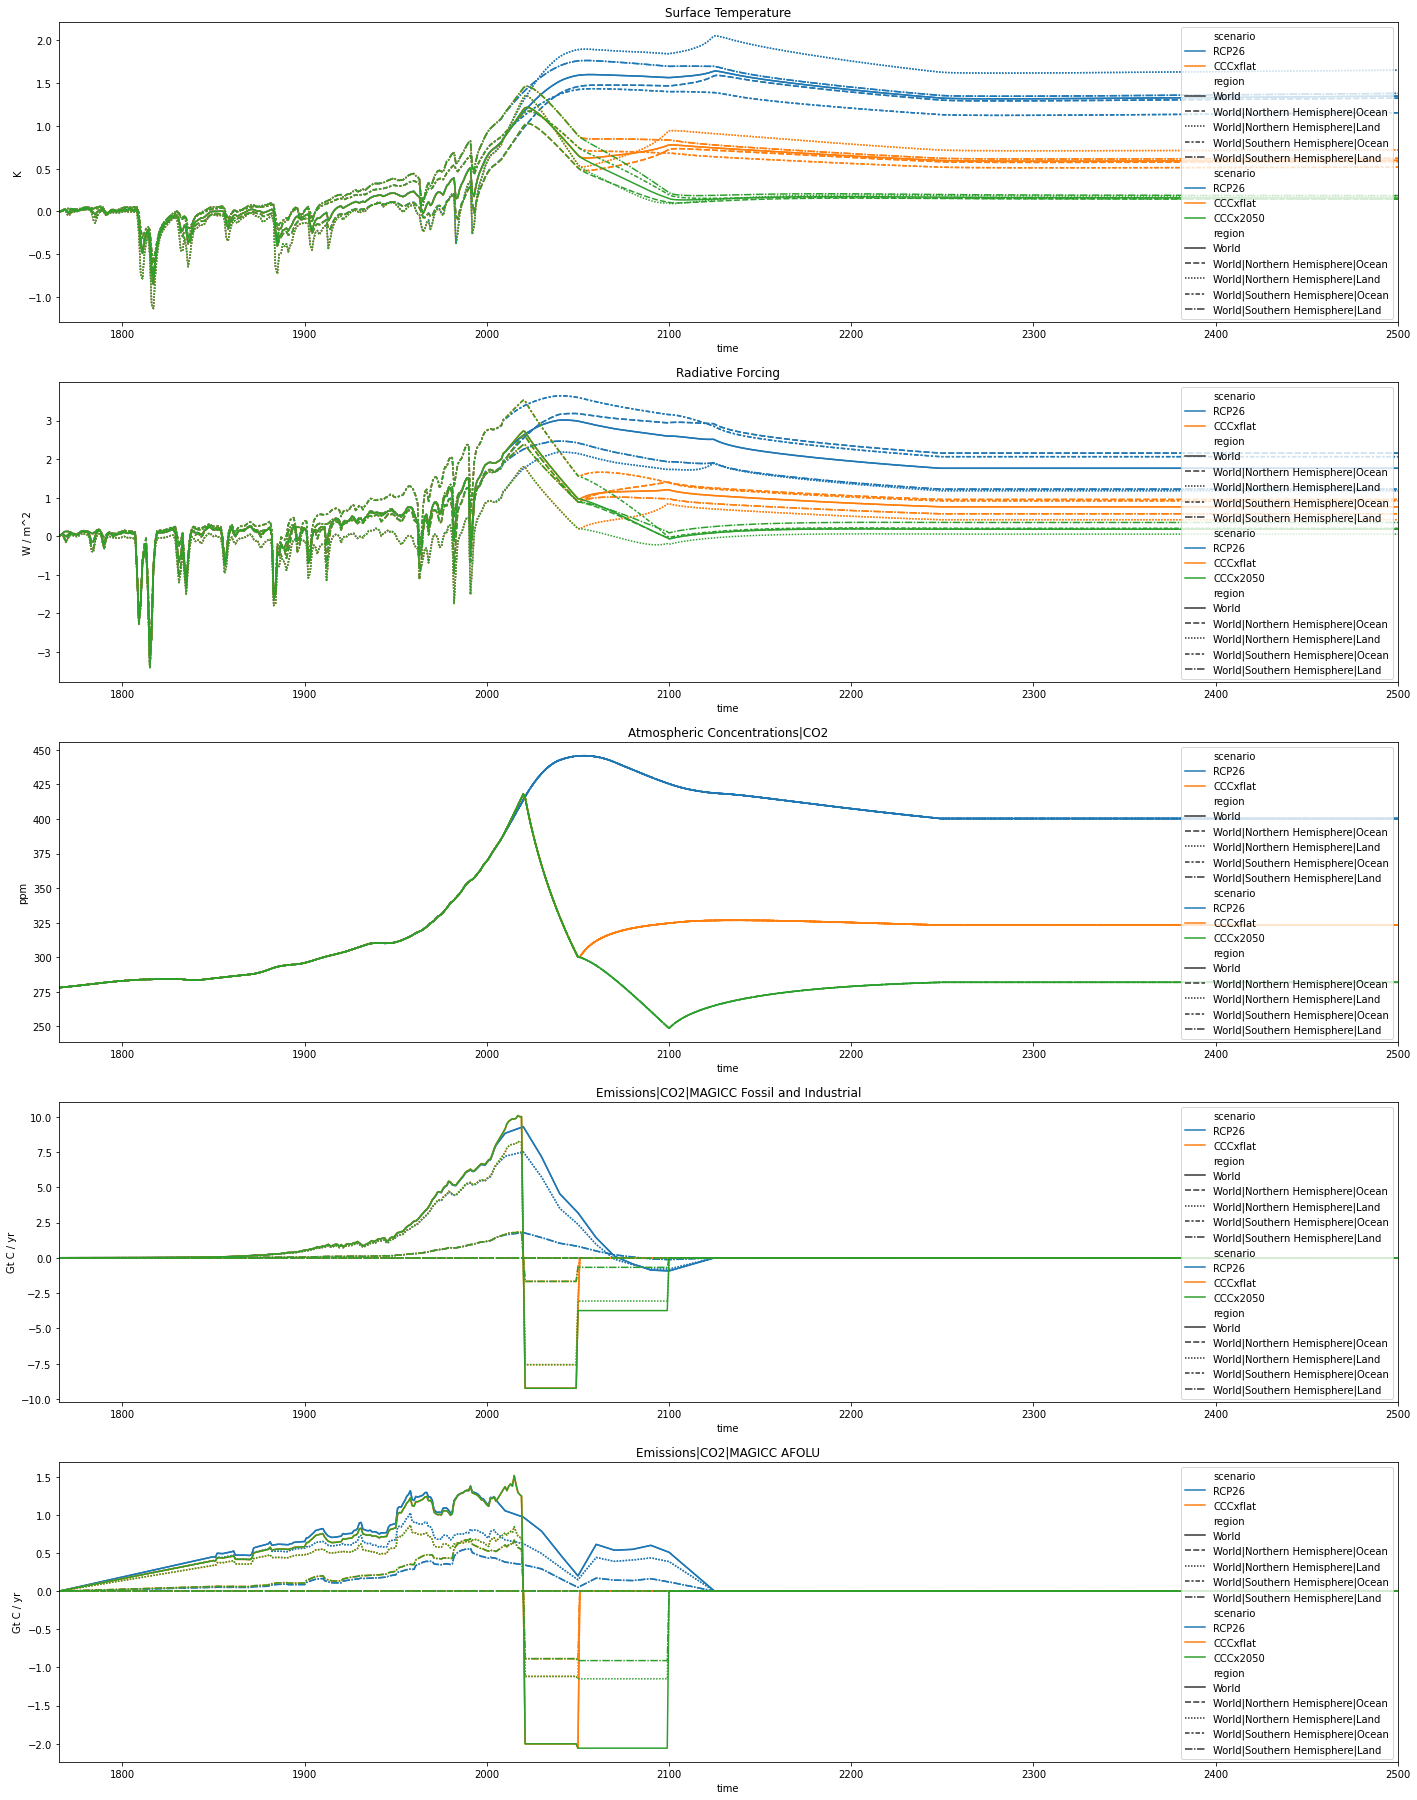

In [10]:
%time res = pymagicc.run(rcp26, **magcfg)  #need to create res of type MAGICCData
fig, axes = plt.subplots((len(vars)), 1, figsize=(24, 32))
for cccsn in CCCxflat,CCCx2050:
    res = res.append(pymagicc.run(cccsn, **magcfg))
    for n, var in enumerate(vars):
        res.filter(variable=var).lineplot(hue="scenario", style="region", ax=axes[n])
        ylab = res.filter(variable=var)["unit"].iloc[[0]].all()
        axes[n].set_ylabel(ylab)
        axes[n].set_title(var)                                 
        axes[n].set_xlim(x)
        axes[n].legend(loc='upper right')


In [11]:
for var in vars,ems_ff:
    print(res.filter(variable = var,region='World').timeseries().loc[:,datetime(2050,1,1)])
    print(res.filter(variable = var,region='World').timeseries().loc[:,datetime(2100,1,1)])

print("Cumulative CO₂ 1750 to 2020")
print(res.filter(variable=ems_ff,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2020,1,1)].sum(axis=1))
print(res.filter(variable=ems_luc,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2020,1,1)].sum(axis=1))
print("Cumulative CO₂ 1750 to 2050")
print(res.filter(variable=ems_ff,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2050,1,1)].sum(axis=1))
print(res.filter(variable=ems_luc,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2050,1,1)].sum(axis=1))
print("Cumulative CO₂ 1750 to 2100")
print(res.filter(variable=ems_ff,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2100,1,1)].sum(axis=1))
print(res.filter(variable=ems_luc,region='World').timeseries().loc[:,datetime(1750,1,1):datetime(2100,1,1)].sum(axis=1))
res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(2045,1,1):datetime(2052,1,1)] >= 300
#res.filter(variable = "Atmospheric Concentrations|CO2",region="World").timeseries().loc[:,datetime(1909,1,1):datetime(1920,1,1)] >= 299


climate_model  model  region  scenario  todo          unit       variable                                  
MAGICC6        IMAGE  World   RCP26     not_relevant  ppm        Atmospheric Concentrations|CO2                445.558590
                                                      W / m^2    Radiative Forcing                               2.984993
                                                      K          Surface Temperature                             1.590459
                                                      Gt C / yr  Emissions|CO2|MAGICC Fossil and Industrial      3.185600
                                                                 Emissions|CO2|MAGICC AFOLU                      0.201200
               CDRex  World   CCCxflat  not_relevant  ppm        Atmospheric Concentrations|CO2                300.130930
                                                      W / m^2    Radiative Forcing                               0.970043
                                      

time                                                                                  2045-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2046-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2047-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2048-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2049-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2050-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                 True   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                 True   

time                                                                                  2051-01-01 00:00:00  \
climate_model model region scenario todo         unit variable                                              
MAGICC6       IMAGE World  RCP26    not_relevant ppm  Atmospheric Concentrations|CO2                 True   
              CDRex World  CCCxflat not_relevant ppm  Atmospheric Concentrations|CO2                False   
                           CCCx2050 not_relevant ppm  Atmospheric Concentrations|CO2                False   

time                                                                                  2052-01-01 00:00:00  
climate_model model region scenario todo         unit variable        

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [ ]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5, endyear=magcfg["endyear"])
default = pymagicc.run(rcp45, core_climatesensitivity=3, endyear=magcfg["endyear"])
high = pymagicc.run(rcp45, core_climatesensitivity=4.5, endyear=magcfg["endyear"])

In [ ]:
filtering = {
    "variable": "Surface Temperature",
    "region": "World",
    "year": range(1850, magcfg["endyear"]),
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
default.filter(**filtering).line_plot(x="time", ax=ax)
plt.fill_between(
    low.filter(**filtering)["time"].values,
    low.filter(**filtering).timeseries().values.squeeze(),
    high.filter(**filtering).timeseries().values.squeeze(),
    color="lightgray"
)

plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");